# Evaluation of 2 Models

In [ ]:
model_1 = "pix2pix_1_0_2"
model_1_type = "pix2pix"
model_2 = "pix2pix_1_0_input_base_2"
model_2_type = "pix2pix"

data_1 = "../../data/nms1000_test_1_1_2500_2500"
data_2 = "../../data/nms1000_test_1_1_2500_2500_input_base"

### Env Setup

In [2]:
!conda create -n eval python=3.8 -y
!conda activate eval

Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/tippolit/anaconda3/envs/eval

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2025.2.25-h06a4308_0 
  ld_impl_linux-64   pkgs/main/linux-64::ld_impl_linux-64-2.40-h12ee557_0 
  libffi             pkgs/main/linux-64::libffi-3.4.4-h6a678d5_1 
  libgcc-ng          pkgs/main/linux-64::libgcc-ng-11.2.0-h1234567_1 
  libgomp            pkgs/main/linux-64::libgomp-11.2.0-h1234567_1 
  libstdcxx-ng       pkgs/main/linux-64::libstdcxx-ng-11.2.0-h1234567_1 
  ncurses            pkgs/main/linux-64::ncurses-6.4-h6a678d5_0 
  openssl            pkgs/main/linux-64::openssl-3.0.16-h5eee18b_0 
  pip                pkgs/main/linux-64::pip-24.2-py38h06a4308_0 


Activate now eval env and run:

In [3]:
!pip install pandas
!pip install ipython
!pip install ipykernel
!pip install opencv-python
!pip install -r requirements.txt

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)


  Using cached ipython-8.12.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached backcall-0.2.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached decorator-5.2.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached jedi-0.19.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached matplotlib_inline-0.1.7-py3-none-any.whl.metadata (3.9 kB)
  Using cached pickleshare-0.7.5-py2.py3-none-any.whl.metadata (1.5 kB)
  Using cached prompt_toolkit-3.0.51-py3-none-any.whl.metadata (6.4 kB)
  Using cached pygments-2.19.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached stack_data-0.6.3-py3-none-any.whl.metadata (18 kB)
  Using cached traitlets-5.14.3-py3-none-any.whl.metadata (10 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached pexpect-4.9.0-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached parso-0.8.4-py2.py3-none-any.whl.metadata (7.7 kB)
  Using cached ptyprocess-0.7.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached wcwidth-0.2.13-py2.py3-n

> Set 'eval' as your python env

### Imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [5]:
!python --version

Python 3.8.20


### Helper

In [21]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    # print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    # print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        # print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        # print(f"Using '{plt_style}' plotting style.")

    # plotting
    # print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2]:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            # print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert)
    return images

### Run Tests

In [ ]:
!python test.py \
  --dataroot {data_1} \
  --name {model_1} \
  --model {model_1_type} \
  --batch_size 18 \
  --dataset_mode noise \
  --input_nc 1 \
  --output_nc 1 \
  --load_size 256 \
  --netG unet_256 \
  --max_dataset_size 1000 \
  --num_test 1000 \
  --results_dir ./eval/{model_1} \
  --phase test \
  --eval

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 18                            	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_1_2500_2500	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: False                         
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
   

In [ ]:
!python test.py \
  --dataroot {data_2} \
  --name {model_2} \
  --model {model_2_type} \
  --batch_size 18 \
  --dataset_mode noise \
  --input_nc 1 \
  --output_nc 1 \
  --load_size 256 \
  --netG unet_256 \
  --max_dataset_size 1000 \
  --num_test 1000 \
  --results_dir ./eval/{model_2} \
  --phase test \
  --eval \
  --different_building_naming

Traceback (most recent call last):
  File "test.py", line 46, in <module>
    opt = TestOptions().parse()  # get test options
  File "/home/tippolit/src/paired_image-to-image_translation/options/base_options.py", line 118, in parse
    opt = self.gather_options()
  File "/home/tippolit/src/paired_image-to-image_translation/options/base_options.py", line 78, in gather_options
    model_option_setter = models.get_option_setter(model_name)
  File "/home/tippolit/src/paired_image-to-image_translation/models/__init__.py", line 50, in get_option_setter
    model_class = find_model_using_name(model_name)
  File "/home/tippolit/src/paired_image-to-image_translation/models/__init__.py", line 33, in find_model_using_name
    modellib = importlib.import_module(model_filename)
  File "/home/tippolit/anaconda3/envs/eval/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, i

### Extract Test Predictions

In [9]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [10]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied real from './eval/pix2pix_1_1/pix2pix_1_1/test_latest/images/buildings_929_real_B.png' to '../../data/eval/pix2pix_1_1/real/buildings_929.png'
[info] copied pred from './eval/pix2pix_1_1/pix2pix_1_1/test_latest/images/buildings_68_fake_B.png' to '../../data/eval/pix2pix_1_1/pred/buildings_68.png'
[info] copied pred from './eval/pix2pix_1_1/pix2pix_1_1/test_latest/images/buildings_595_fake_B.png' to '../../data/eval/pix2pix_1_1/pred/buildings_595.png'
[info] copied real from './eval/pix2pix_1_1/pix2pix_1_1/test_latest/images/buildings_70_real_B.png' to '../../data/eval/pix2pix_1_1/real/buildings_70.png'
[info] copied real from './eval/pix2pix_1_1/pix2pix_1_1/test_latest/images/buildings_389_real_B.png' to '../../data/eval/pix2pix_1_1/real/buildings_389.png'
[info] copied real from './eval/pix2pix_1_1/pix2pix_1_1/test_latest/images/buildings_689_real_B.png' to '../../data/eval/pix2pix_1_1/real/buildings_689.png'
[info] copied real from './eval/pix2pix_1_1/pix2pix_1_1/test_l

In [11]:
evaluation_path = f"./eval/{model_2}/{model_2}/test_latest/images"
target_path = f"../../data/eval/{model_2}"

In [12]:
!python eval_extractor.py \
    --name {model_2} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied pred from './eval/pix2pix_1_1_input_base/pix2pix_1_1_input_base/test_latest/images/888_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_1_input_base/pred/888_LAEQ.png'
[info] copied real from './eval/pix2pix_1_1_input_base/pix2pix_1_1_input_base/test_latest/images/634_LAEQ_256_real_B.png' to '../../data/eval/pix2pix_1_1_input_base/real/634_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_1_input_base/pix2pix_1_1_input_base/test_latest/images/855_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_1_input_base/pred/855_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_1_input_base/pix2pix_1_1_input_base/test_latest/images/745_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_1_input_base/pred/745_LAEQ.png'
[info] copied real from './eval/pix2pix_1_1_input_base/pix2pix_1_1_input_base/test_latest/images/468_LAEQ_256_real_B.png' to '../../data/eval/pix2pix_1_1_input_base/real/468_LAEQ.png'
[info] copied real from './eval/pix2pix_1_1_input_base/pix2pix_1_1_input_base/te

### Calc Eval metrics

In [13]:
!python eval_metrics.py\
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples: 100%|██████████████████| 1000/1000 [00:02<00:00, 385.64it/s]
               MAE         MAPE
count  1000.000000  1000.000000
mean      2.437824    12.957809
std       1.167886     5.050747
min       0.564791     2.805113
25%       1.561237     9.576255
50%       2.245761    12.271848
75%       3.093089    15.782112
max       7.825000    32.032650


In [14]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_2}/real \
    --pred_dir ../../data/eval/{model_2}/pred \
    --output ./eval_results/evaluation_{model_2}.csv

Evaluating samples: 100%|██████████████████| 1000/1000 [00:02<00:00, 424.96it/s]
               MAE         MAPE
count  1000.000000  1000.000000
mean      0.549294     3.906135
std       0.281758     2.113693
min       0.174130     0.847364
25%       0.324324     2.177310
50%       0.473492     3.574733
75%       0.719545     5.234236
max       2.264650    15.538480


### Show Results

In [23]:
mae_model_1_name = f'MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'

mae_model_2_name = f'MAE_{model_2}'
mape_model_2_name = f'MAPE_{model_2}'

In [24]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 'MAPE':mape_model_1_name})
df_1["sample_id"] = df_1["sample_id"].str.extract(r'_*(\d+)_*')[0].astype(int)
df_1

,sample_id,MAE_pix2pix_1_1,MAPE_pix2pix_1_1
0,893,1.189138,7.780590
1,109,1.531258,11.199695
2,788,3.598076,20.863823
3,974,2.729336,12.596258
4,570,2.218227,12.175036
...,...,...,...
995,247,1.219405,6.869993
996,717,2.775962,14.021179
997,366,2.930130,14.799505
998,503,1.755479,8.986580


In [25]:
df_2 = pd.read_csv(f"./eval_results/evaluation_{model_2}.csv")
df_2 = df_2.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_2 = df_2.rename(columns={'MAE': mae_model_2_name, 'MAPE':mape_model_2_name})
df_2["sample_id"] = df_2["sample_id"].str.extract(r'^(\d+)_')[0].astype(int)
df_2

,sample_id,MAE_pix2pix_1_1_input_base,MAPE_pix2pix_1_1_input_base
0,707,0.532741,4.052048
1,283,0.826015,5.723983
2,584,0.798765,6.793016
3,967,0.762299,4.664948
4,132,1.059594,8.028384
...,...,...,...
995,92,0.406835,3.110961
996,435,0.597474,5.233915
997,197,0.602094,4.407036
998,689,0.328088,2.018785


In [26]:
merged_df = pd.merge(df_1, df_2, on='sample_id', how='outer')
print(f"Value Counts:\n{merged_df.value_counts()}")
print(f"\n\nNulls:\n{merged_df.isna().sum()}\n\n")
merged_df

Value Counts:
sample_id  MAE_pix2pix_1_1  MAPE_pix2pix_1_1  MAE_pix2pix_1_1_input_base  MAPE_pix2pix_1_1_input_base
0          1.707620         9.635275          0.319304                    2.144043                       1
671        3.418483         14.652892         0.235273                    1.379666                       1
658        1.056447         7.354140          0.393898                    3.258371                       1
659        0.955769         5.704448          0.314247                    2.150802                       1
660        1.198730         11.560124         0.680781                    5.690459                       1
                                                                                                        ..
338        3.912587         17.806423         0.356056                    2.488709                       1
339        1.996908         9.911608          0.447244                    2.899086                       1
340        3.074065         

,sample_id,MAE_pix2pix_1_1,MAPE_pix2pix_1_1,MAE_pix2pix_1_1_input_base,MAPE_pix2pix_1_1_input_base
0,893,1.189138,7.780590,0.462634,3.296086
1,109,1.531258,11.199695,0.792230,6.000245
2,788,3.598076,20.863823,1.205791,8.548368
3,974,2.729336,12.596258,0.807184,4.616497
4,570,2.218227,12.175036,0.292598,1.971079
...,...,...,...,...,...
995,247,1.219405,6.869993,0.328016,2.200634
996,717,2.775962,14.021179,0.716553,5.256492
997,366,2.930130,14.799505,0.513605,4.231072
998,503,1.755479,8.986580,0.368784,2.368263


Using 'seaborn-v0_8' plotting style.

MAE
    - pix2pix_1_1: 2.44
    - pix2pix_1_1_input_base: 0.55

MAPE
    - pix2pix_1_1: 12.96
    - pix2pix_1_1_input_base: 3.91


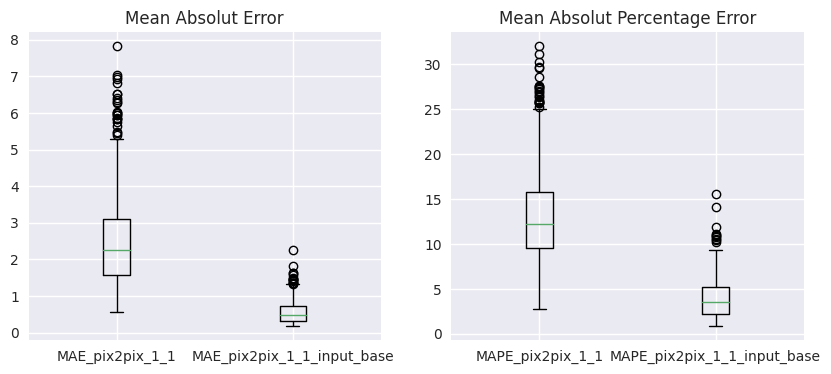

In [44]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
ax = ax.flatten()

values = [merged_df[mae_model_1_name], merged_df[mae_model_2_name]]
names = [mae_model_1_name, mae_model_2_name]
ax[0].boxplot(x=values, notch=False)
ax[0].set_xticks([1, 2], names)
ax[0].set_title("Mean Absolut Error")

values = [merged_df[mape_model_1_name], merged_df[mape_model_2_name]]
names = [mape_model_1_name, mape_model_2_name]
ax[1].boxplot(x=values, notch=False)
ax[1].set_xticks([1, 2], names)
ax[1].set_title("Mean Absolut Percentage Error")

print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mae_model_2_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mape_model_2_name].mean():>0.2f}")

Example Image

Examples from pix2pix_1_1


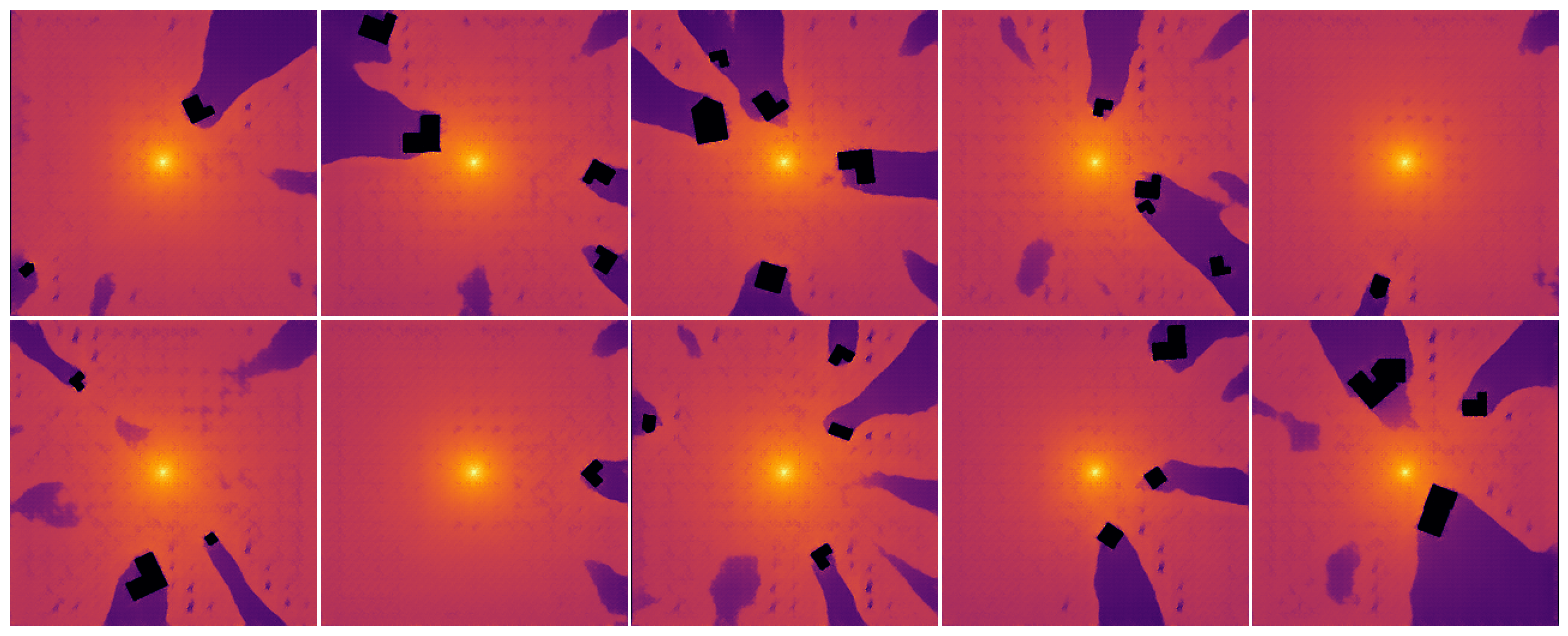

Examples from pix2pix_1_1_input_base


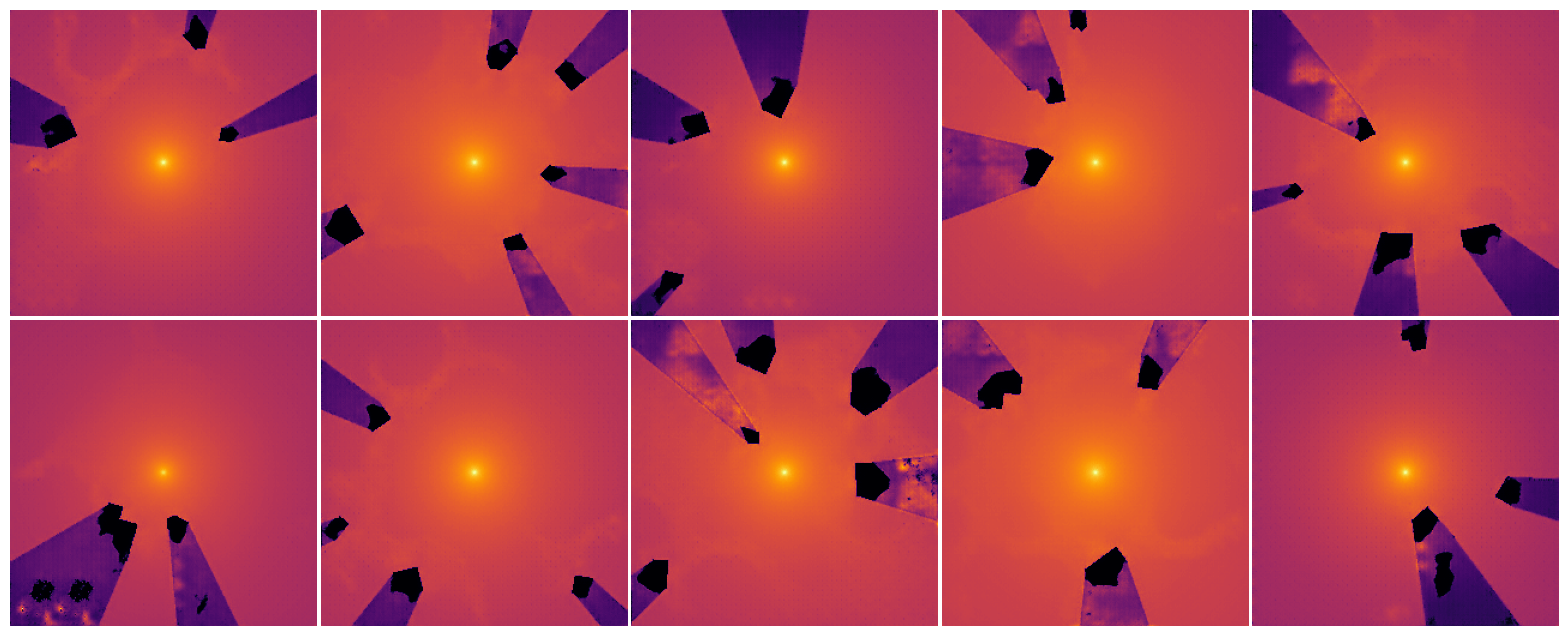

In [45]:
path = f"../../data/eval/{model_1}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_1}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="inferno", color_space="grey", invert=True)

path = f"../../data/eval/{model_2}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_2}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="inferno", color_space="grey", invert=True);